# Catboost model challange  
ref:https://www.kaggle.com/braquino/catboost-some-more-features

### Update notes  

I have added some new very simple features to this kernel:  
1. How much time was spent in each Title  
2. How many actions was registered in each event_code  

### Commentator notes  

This kernel isn't mine, so, if you liked it, upvote this official one made by Massoud Hosseinali: https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model  
I find this kernel so good and elegant, and also is the top score public on this competition, then I decided to use it as baseline for my attempts, so I have scrutinated the whole notebook and left comments on almost each line.  
I think this comments can help who wants to use it as baseline aswell, I hope you enjoy the comments and forgive me the english errors.  
  
Massoud, if you see any problem doing this, or any error in my comments, tell me please. And congratulations for this kernel.   

### Kernel creator notes  

I had posted my very naive baseline at https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019. In that kernel I only used the mode label for each Assessment and I thought it should be very easy to beat. This kernel shows how you can beat that baseline by actually applying a model. In this kernel via `get_data()` function, I go over each `installation_id` and try to extract some features based on his/her behavior prior to the assessment. I will then train a `Catboost` classifier on it and make predictions on the test set. Note that the features I made in this kernel are so very basic and you can easily add many more to it. Good luck and happy kaggling. Don't forget to upvote if you found it useful ;)

In [1]:
import numpy as np
import pandas as pd
import datetime
from catboost import CatBoostClassifier
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
pd.set_option('display.max_columns', 200)

In [2]:
from sklearn.metrics import confusion_matrix
# this function is the quadratic weighted kappa (the metric used for the competition submission)
def qwk(act,pred,n=4,hist_range=(0,3)):
    
    # Calculate the percent each class was tagged each label
    O = confusion_matrix(act,pred)
    # normalize to sum 1
    O = np.divide(O,np.sum(O))
    
    # create a new matrix of zeroes that match the size of the confusion matrix
    # this matriz looks as a weight matrix that give more weight to the corrects
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            # makes a weird matrix that is bigger in the corners top-right and botton-left (= 1)
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    # make two histograms of the categories real X prediction
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    # multiply the two histograms using outer product
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E)) # normalize to sum 1
    
    # apply the weights to the confusion matrix
    num = np.sum(np.multiply(W,O))
    # apply the weights to the histograms
    den = np.sum(np.multiply(W,E))
    
    return 1-np.divide(num,den)
    

In [3]:
train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')

In [4]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [5]:
train.shape

(11341042, 11)

In [6]:
train.game_session.nunique()
#303319
train.installation_id.nunique()
#17000
#So, 17000 users make 303319 settion, one user's average number of session is 17.8.  
#And whole records are 11341042, so one user's one session's average number of event is 37.  
#This give me insights. I think this type of data aggregation's smallest unit is game_session.

17000

In [7]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [8]:
# encode title
# make a list with all the unique 'titles' from the train and test set
list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
# make a list with all the unique 'event_code' from the train and test set
list_of_event_code = list(set(train['event_code'].value_counts().index).union(set(test['event_code'].value_counts().index)))
# create a dictionary numerating the titles
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

# replace the text titles withing the number titles from the dict
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)
train_labels['title'] = train_labels['title'].map(activities_map)

In [9]:
print(list_of_event_code)

[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 2040, 4090, 4220, 4095]


In [10]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,6,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,33,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,29,Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,29,Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,29,Activity,MAGMAPEAK


In [11]:
# I didnt undestud why, but this one makes a dict where the value of each element is 4100 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
# then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [12]:
print(win_code) #I think above code don't necessity

{0: 4100, 1: 4100, 2: 4100, 3: 4100, 4: 4100, 5: 4100, 6: 4100, 7: 4100, 8: 4100, 9: 4100, 10: 4100, 11: 4100, 12: 4100, 13: 4100, 14: 4100, 15: 4100, 16: 4100, 17: 4100, 18: 4100, 19: 4100, 20: 4100, 21: 4100, 22: 4100, 23: 4100, 24: 4100, 25: 4110, 26: 4100, 27: 4100, 28: 4100, 29: 4100, 30: 4100, 31: 4100, 32: 4100, 33: 4100, 34: 4100, 35: 4100, 36: 4100, 37: 4100, 38: 4100, 39: 4100, 40: 4100, 41: 4100, 42: 4100, 43: 4100}


In [13]:
# convert text into datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [14]:
train[train["type"]=="Assessment"].head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2185,3bfd1a65,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,2,Assessment,TREETOPCITY
2186,db02c830,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,2,Assessment,TREETOPCITY
2187,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,2,Assessment,TREETOPCITY
2188,a52b92d5,901acc108f55a5a1,2019-08-06 05:22:05.242000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,2,Assessment,TREETOPCITY
2189,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:05.244000+00:00,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,2,Assessment,TREETOPCITY


In [15]:
test.head(10)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,6,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,33,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,32,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,8,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,31,Game,CRYSTALCAVES
5,f93fc684,a022c3f60ba547e7,2019-09-10 16:54:14.338000+00:00,"{""coordinates"":{""x"":515,""y"":697,""stage_width"":...",00abaee7,2,4010,2232,31,Game,CRYSTALCAVES
6,7ec0c298,a022c3f60ba547e7,2019-09-10 16:54:16.553000+00:00,"{""description"":""It's Chow Time! We have some V...",00abaee7,3,3010,4445,31,Game,CRYSTALCAVES
7,0d1da71f,a022c3f60ba547e7,2019-09-10 16:54:23.364000+00:00,"{""description"":""It's Chow Time! We have some V...",00abaee7,4,3110,11251,31,Game,CRYSTALCAVES
8,63f13dd7,a022c3f60ba547e7,2019-09-10 16:54:23.365000+00:00,"{""dinosaur"":""stacey"",""diet"":""herbivore"",""targe...",00abaee7,5,2020,11251,31,Game,CRYSTALCAVES
9,7372e1a5,a022c3f60ba547e7,2019-09-10 16:54:25.029000+00:00,"{""coordinates"":{""x"":901,""y"":449,""stage_width"":...",00abaee7,6,4070,12929,31,Game,CRYSTALCAVES


In [16]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        
        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            features['installation_id'] = session['installation_id'].iloc[0]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [17]:
# here the get_data function is applyed to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=17000):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

In [18]:
# the compiled_data is converted to DataFrame and deleted to save memmory
new_train = pd.DataFrame(compiled_data)
del compiled_data
new_train.shape

(17690, 103)

In [19]:
new_train.head(10)

,Clip,Activity,Assessment,Game,Dino Dive,Dino Drink,Mushroom Sorter (Assessment),Scrub-A-Dub,Flower Waterer (Activity),Ordering Spheres,Welcome to Lost Lagoon!,12 Monkeys,Crystal Caves - Level 1,Pan Balance,"Heavy, Heavier, Heaviest",Crystal Caves - Level 2,Tree Top City - Level 2,Fireworks (Activity),Watering Hole (Activity),All Star Sorting,Tree Top City - Level 3,Cart Balancer (Assessment),Treasure Map,Tree Top City - Level 1,Leaf Leader,Bug Measurer (Activity),Crystals Rule,Honey Cake,Costume Box,Bird Measurer (Assessment),Chicken Balancer (Activity),Lifting Heavy Things,Pirate's Tale,Sandcastle Builder (Activity),Air Show,Chow Time,Magma Peak - Level 2,Magma Peak - Level 1,Bubble Bath,Happy Camel,Crystal Caves - Level 3,Egg Dropper (Activity),Bottle Filler (Activity),Balancing Act,Chest Sorter (Assessment),Slop Problem,Rulers,Cauldron Filler (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,0,0,0,115,164,0,0,0,0,0,0,0,0,91,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,4,1,2,77,4,7,9,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0,0006a69f,2,0,0,0.00,0.000000,3,0,0,0,0,0.0,647
1,14,4,1,6,0,0,0,115,164,0,0,0,0,0,0,0,0,91,0,163,0,0,0,0,0,104,78,0,0,0,0,0,0,89,193,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,0,0,0,1,2,0,1,0,4,1,2,223,6,11,16,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0,0006a69f,25,1,0,39.00,1.000000,0,0,0,0,1,3.0,1143
2,14,4,2,6,0,0,0,115,164,0,0,0,0,0,0,0,0,91,0,163,0,0,0,0,0,104,78,0,0,0,0,0,0,89,193,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,0,0,0,1,13,0,1,0,4,1,2,225,6,22,16,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0,0006a69f,2,1,11,65.50,0.500000,3,1,0,0,1,1.5,1230
3,24,9,4,10,0,110,0,195,254,0,0,0,0,0,0,0,0,1611,80,229,0,0,0,0,0,104,78,0,0,0,0,0,0,126,193,0,0,0,133,0,0,0,165,0,0,0,0,0,9,6,0,5,0,2,13,5,2,0,8,2,5,336,10,25,40,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,9,1,0006a69f,2,2,11,41.25,0.500000,2,2,0,0,2,1.5,2159
4,28,10,5,13,0,110,0,195,254,0,0,0,0,0,0,0,0,1611,80,229,0,0,0,0,0,184,310,0,0,0,0,0,0,126,336,0,0,0,133,0,0,0,165,0,0,0,0,0,9,12,0,5,0,3,13,5,2,1,8,2,5,457,12,30,53,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,9,1,0006a69f,25,3,12,39.20,0.500000,3,2,0,1,2,1.6,2586
5,15,6,0,4,151,0,0,162,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,79,0,0,0,0,0,0,0,338,0,81,0,0,96,0,0,0,395,0,0,0,0,0,5,0,6,0,6,1,0,0,1,0,4,1,3,197,5,23,15,121,65,0,8,192,0,199,30,8,23,16,1,25,0,0,46,482,1,43,0,1,6,2,5,1,0006c192,43,0,0,0.00,0.000000,3,0,0,0,0,0.0,1542
6,28,8,2,5,151,0,0,162,267,0,0,0,0,25,0,0,0,0,21,0,0,0,0,0,0,79,0,0,0,0,106,0,0,338,0,81,0,0,96,0,0,0,395,0,0,0,0,0,5,1,6,0,6,1,0,0,1,0,4,1,3,235,6,23,16,168,65,37,24,287,0,240,45,8,23,18,1,43,0,0,49,521,1,44,0,1,6,3,5,1,0006c192,2,1,0,7.00,0.500000,0,1,0,0,1,1.5,1898
7,30,8,3,6,151,0,0,162,267,0,0,0,0,25,0,0,0,0,21,0,0,0,0,0,0,79,11,0,0,0,106,0,0,338,0,81,0,0,96,0,0,0,395,0,0,0,0,0,5,5,6,0,6,1,0,0,1,0,4,1,3,240,7,27,19,176,65,37,27,301,0,246,45,14,27,21,1,47,0,0,50,577,2,44,0,2,6,3,5,1,0006c192,25,1,4,35.00,0.333333,2,2,0,0,1,1.0,2022
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,00129856,25,0,0,0.00,0.000000,3,1,0,0,0,0.0,3
9,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,001d0ed0,2,0,0,0.00,0.000000,2,0,0,0,0,0.0,6


In [20]:
del train

In [21]:
# process test set, the same that was done with the train set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
X_test = pd.DataFrame(new_test)
del test

In [22]:
X_test.head(10)

,Clip,Activity,Assessment,Game,Dino Dive,Dino Drink,Mushroom Sorter (Assessment),Scrub-A-Dub,Flower Waterer (Activity),Ordering Spheres,Welcome to Lost Lagoon!,12 Monkeys,Crystal Caves - Level 1,Pan Balance,"Heavy, Heavier, Heaviest",Crystal Caves - Level 2,Tree Top City - Level 2,Fireworks (Activity),Watering Hole (Activity),All Star Sorting,Tree Top City - Level 3,Cart Balancer (Assessment),Treasure Map,Tree Top City - Level 1,Leaf Leader,Bug Measurer (Activity),Crystals Rule,Honey Cake,Costume Box,Bird Measurer (Assessment),Chicken Balancer (Activity),Lifting Heavy Things,Pirate's Tale,Sandcastle Builder (Activity),Air Show,Chow Time,Magma Peak - Level 2,Magma Peak - Level 1,Bubble Bath,Happy Camel,Crystal Caves - Level 3,Egg Dropper (Activity),Bottle Filler (Activity),Balancing Act,Chest Sorter (Assessment),Slop Problem,Rulers,Cauldron Filler (Assessment),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,14,7,1,3,188,0,0,0,0,0,0,0,0,0,0,0,0,194,0,1960,0,0,0,0,0,33,0,0,0,0,0,0,0,90,0,135,0,0,0,0,0,88,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,108,3,33,9,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,0,00abaee7,43,1,0,30.000000,1.000000,0,0,0,0,1,3.000000,867
1,29,11,5,12,155,159,0,162,178,0,0,0,0,129,0,0,0,173,73,64,0,0,0,0,67,74,169,0,0,0,108,0,0,334,123,110,0,0,96,181,0,317,348,0,0,0,0,0,6,23,0,4,0,4,3,4,1,3,10,2,7,416,12,25,72,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,9,0,01242218,17,4,7,49.600000,0.466667,0,1,1,2,1,1.600000,2718
2,6,2,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,0,017c5718,2,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,149
3,10,2,0,1,0,0,0,0,85,0,0,0,0,0,0,0,0,25,0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,1,2,3,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,0,01a44906,2,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,233
4,17,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,610,0,0,0,0,0,0,0,0,0,0,221,0,0,0,0,218,0,0,0,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,6,27,27,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,0,5,01bc6cb6,17,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,951
5,6,4,1,2,0,0,0,0,0,0,0,0,0,405,0,0,0,0,435,0,0,0,0,0,0,0,0,0,0,0,364,0,0,0,0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,16,0,0,0,16,0,0,0,0,0,74,2,8,19,124,43,3,52,139,0,74,28,0,8,19,0,13,0,1,19,136,0,18,0,0,0,2,0,0,02256298,17,1,0,27.000000,1.000000,0,0,0,0,1,3.000000,832
6,13,2,0,5,0,577,0,0,0,0,0,0,0,0,0,0,0,167,0,393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,85,5,48,53,125,0,0,0,147,21,88,23,0,48,53,0,20,0,0,37,84,4,33,0,0,0,0,0,9,0267757a,2,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,887
7,17,9,9,7,0,0,0,20,212,0,0,0,0,0,0,0,0,182,20,88,0,0,0,0,83,82,0,0,0,0,143,0,0,52,141,127,0,0,0,88,0,175,291,0,0,0,0,0,0,12,0,0,0,3,1,0,0,3,2,1,1,240,7,12,29,272,9,44,50,369,0,244,61,22,12,30,2,42,0,7,43,227,2,35,0,2,1,0,0,0,027e7ce5,25,7,2,34.555556,0.703704,0,2,1,0,6,2.111111,1785
8,10,3,3,5,248,0,0,309,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,139,174,0,0,0,0,0,0,59,0,213,0,0,143,0,0,0,28,0,0,0,0,0,9,2,8,0,8,1,13,0,1,0,8,0,8,235,6,102,41,140,10,0,47,164,0,239,41,13,103,41,2,21,0,0,59,323,2,50,0,2,10,0,0,3,02a29f99,40,1,14,52.000000,0.166667,0,2,0,1,0,0.666667,1712
9,15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,16,0,0,1,1,0,0,0,0,0,0,0,0,0300c576,17,0,0,0.000000,0.000000,0,0,0,0,0,0.000000,23


In [23]:
X_test.shape

(1000, 103)

In [24]:
#If you don't use installation_id, drop them.
new_train = new_train.drop(["installation_id"],axis=1)
X_test = X_test.drop(["installation_id"],axis=1)

## Model

In [25]:
# this list comprehension create the list of features that will be used on the input dataset X
# all but accuracy_group, that is the label y
all_features = [x for x in new_train.columns if x not in ['accuracy_group']]
# this cat_feature must be declared to pass later as parameter to fit the model
cat_features = ['session_title']
# here the dataset select the features and split the input ant the labels
X, y = new_train[all_features], new_train['accuracy_group']
#del train
X.shape

(17690, 101)

In [26]:
# this function makes the model and sets the parameters
# for configure others parameter consult the documentation below:
# https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html
def make_classifier(iterations=2000):
    clf = CatBoostClassifier(
                               loss_function='MultiClass',
                               eval_metric="WKappa",
                               task_type="CPU",
                               learning_rate=0.01,
                               iterations=iterations,
                               od_type="Iter",
                               depth=4,
                               early_stopping_rounds=500,
                               l2_leaf_reg=10,
                               border_count=96,
        max_leaves =200, 
        min_data_in_leaf = 10,
        subsample = 1,
        random_seed = 71, 
        verbose=500, 
                                #use_best_model=use_best_model
                              )
        
    return clf

# Optimize hyper parameters using by Optuna

In [27]:
import optuna

In [28]:
# CV
from sklearn.model_selection import KFold
# oof is an zeroed array of the same size of the input dataset
oof = np.zeros(len(X))
NFOLDS = 5
# here the KFold class is used to split the dataset in 5 diferents training and validation sets
# this technique is used to assure that the model isn't overfitting and can performs aswell in 
# unseen data. More the number of splits/folds, less the test will be impacted by randomness
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=71)

def objective(trial): 
    depth = trial.suggest_int('depth', 4, 10) 
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 10) 
    learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1.0) 
    #subsample = trial.suggest_uniform('subsample', 0.5, 1.0) 
    #max_leaves = trial.suggest_int('max_leaves', 5, 200) 
    #min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 200) 
    
    training_start_time = time()
    models = []
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
        # each iteration of folds.split returns an array of indexes of the new training data and validation data
        start_time = time()
        print(f'Training on fold {fold+1}')
        # creates the model
        # this function makes the model and sets the parameters
        clf = CatBoostClassifier(
                               loss_function='MultiClass',
                               eval_metric="WKappa",
                               task_type="CPU",
                               learning_rate=learning_rate,
                               iterations=2000,
                               od_type="Iter",
                               depth=depth,
                               early_stopping_rounds=500,
                               l2_leaf_reg=l2_leaf_reg,
                               border_count=96,
                               #max_leaves = max_leaves, 
                               #min_data_in_leaf = min_data_in_leaf,
                               #subsample = subsample, #this parameter only use bootstrap_type Poisson or Bernoulli
                               random_seed = 71, 
                               verbose=500, 
                                #use_best_model=use_best_model
                              )
        # fits the model using .loc at the full dataset to select the splits indexes and features used
        clf.fit(X.loc[trn_idx, all_features], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_features], y.loc[test_idx]),
                          use_best_model=True,verbose=500, cat_features=cat_features)
          
        # then, the predictions of each split is inserted into the oof array
        oof[test_idx] = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
        models.append(clf)
        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
        print('____________________________________________________________________________________________\n')
        #break
    
    print('-' * 30)
    # and here, the complete oof is tested against the real data using que metric (quadratic weighted kappa)
    print('OOF QWK:', qwk(y, oof))
    print('-' * 30)

    return -qwk(y, oof)

if __name__ == "__main__":
    study = optuna.create_study()
    study.optimize(objective, n_trials=10)
    print("params_{}".format(study.best_params))
    print("value_{}".format(study.best_value))

# Set optimized hyper parameters and Run

In [29]:
# CV
from sklearn.model_selection import KFold
# oof is an zeroed array of the same size of the input dataset
oof = np.zeros(len(X))
NFOLDS = 5
# here the KFold class is used to split the dataset in 5 diferents training and validation sets
# this technique is used to assure that the model isn't overfitting and can performs aswell in 
# unseen data. More the number of splits/folds, less the test will be impacted by randomness
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
training_start_time = time()
models = []
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    # each iteration of folds.split returns an array of indexes of the new training data and validation data
    start_time = time()
    print(f'Training on fold {fold+1}')
    # creates the model
    clf = CatBoostClassifier(
                               loss_function='MultiClass',
                               eval_metric="WKappa",
                               task_type="CPU",
                               learning_rate=0.2088,
                               iterations=2000,
                               od_type="Iter",
                               depth=8,
                               early_stopping_rounds=500,
                               l2_leaf_reg=8,
                               border_count=96,
                               #max_leaves = max_leaves, 
                               #min_data_in_leaf = min_data_in_leaf,
                               #subsample = subsample, #this parameter only use bootstrap_type Poisson or Bernoulli
                               random_seed = 71, 
                               verbose=500, 
                                #use_best_model=use_best_model
                              )
    # fits the model using .loc at the full dataset to select the splits indexes and features used
    clf.fit(X.loc[trn_idx, all_features], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_features], y.loc[test_idx]),
                          use_best_model=True, verbose=500, cat_features=cat_features)
    
    # then, the predictions of each split is inserted into the oof array
    oof[test_idx] = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
    models.append(clf)
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    print('____________________________________________________________________________________________\n')
    #break
    
print('-' * 30)
# and here, the complete oof is tested against the real data using que metric (quadratic weighted kappa)
print('OOF QWK:', qwk(y, oof))
print('-' * 30)

Training on fold 1
0:	learn: 0.4776986	test: 0.4807045	best: 0.4807045 (0)	total: 170ms	remaining: 5m 39s
500:	learn: 0.7966296	test: 0.5310499	best: 0.5352444 (281)	total: 53.6s	remaining: 2m 40s
1000:	learn: 0.9124873	test: 0.5302820	best: 0.5370780 (602)	total: 1m 46s	remaining: 1m 46s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5370779875
bestIteration = 602

Shrink model to first 603 iterations.
Fold 1 finished in 0:01:57.787336
____________________________________________________________________________________________

Training on fold 2
0:	learn: 0.4801784	test: 0.4535038	best: 0.4535038 (0)	total: 121ms	remaining: 4m 1s
500:	learn: 0.8043033	test: 0.5373669	best: 0.5398819 (449)	total: 53s	remaining: 2m 38s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5398819028
bestIteration = 449

Shrink model to first 450 iterations.
Fold 2 finished in 0:01:40.818803
____________________________________________________________________________

In [30]:
# make predictions on test set once
predictions = []
for model in models:
    predictions.append(model.predict(X_test))
predictions = np.concatenate(predictions, axis=1)
print(predictions.shape)
predictions = stats.mode(predictions, axis=1)[0].reshape(-1)
print(predictions.shape)
#del X_test

(1000, 5)
(1000,)


## Make submission

In [31]:
submission['accuracy_group'] = np.round(predictions).astype('int')
submission.to_csv('submission.csv', index=None)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


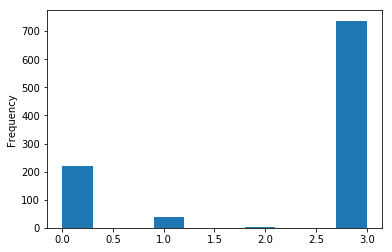

In [32]:
submission['accuracy_group'].plot(kind='hist')

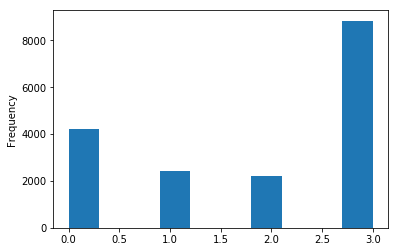

In [33]:
train_labels['accuracy_group'].plot(kind='hist')

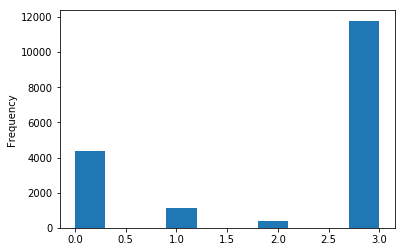

In [34]:
pd.Series(oof).plot(kind='hist')